# Capatone Project - Road Users Protection Improvement

## Background
In UK, over 1700 people were killed by traffic accidents every year, and hundreds of thousands injured. These accidents have torn families apart, troubled the communities, and damaged properties. There are many causes to traffic accidents such as bad road using habits or unsafe road design. It is everyone's responsibility to keep the road safe.

The UK Department for Transport revealed that the number of casualties remained broadly consistent in the last 10 years, except for a drop in 2020 due to lockdown for the coronavirus pandemic. The Department also discovered that the number of accidents changed along with traffic volumes.

In this project, we will look into different factors of the road, vehicle and casualty in order to find a pattern of the accidents. Then we can use that information to develop strategies to 
1. reduce the number of accidents
2. protect road users when an accident happens

## Dataset
Datasets:  
- Road Safety Data - Accidents 2019  
- Road Safety Data - Vehicles 2019  
- Road Safety Data - Casualties 2019  

Source: Department for Transport  
Link: https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data  
Volume: 117536 accidents, 71 Attributes  
Reliability: Very reliable  
Quality: High  
Data Generation: Info gathered by police  
Ongoing basis: No. New report published in every September

## Table of Contents
1. Import Libraries
2. Load Data
3. Clean Data
4. EDA
5. Prediction of Casualty Severity / Casualty Type  
    5.1 Feature Engineering  
    5.2 Modelling  
        5.2.1 Decision Tree  
        5.2.2 Random Forest  
        5.2.3 Extra Trees  
        5.2.4 Ada Boost  
        5.2.5 LightGBM  
        5.2.6 K-Nearest Neighbors  
    5.3 Testing
6. Identify Casualty Severity Groups by Roads
7. Conclusion

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import time

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import metrics
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 2. Load Data

In [2]:
# Connect to SQL database
conn = sqlite3.connect("uk_road_2019.sqlite")
# Create a cursor
c = conn.cursor()

In [3]:
# Read dataframe
df = pd.read_csv("df.csv")
df.rename(columns={"1st_Road_Class": "Road_Class", "Pedestrian_Crossing-Physical_Facilities": "Crossing_Facilities"}, 
          inplace=True)

## 3. Clean Data
See Capstone_DataCleaning.ipynb
## 4. EDA
See Capstone_EDA.ipynb

## 5. Prediction of Casualty Severity / Casualty Type

### 5.1 Feature Engineering

In [4]:
# Add target variables to main dataframe
df_cas = pd.read_sql_query("""
SELECT id, 
       casualty_type, 
       casualty_severity 
FROM casualties 
GROUP BY id;
""", conn)

df_cas["Road_User_Type"] = df_cas["casualty_type"].map({"Pedestrian": 0, 
                                                        "Cyclist": 1, 
                                                        "Motorcycle 050cc and under \nrider or passenger": 2, 
                                                        "Motorcycle 050cc to 125cc \nrider or passenger": 3, 
                                                        "Motorcycle 125cc to 500cc \nrider or  passenger": 4, 
                                                        "Motorcycle 500cc and over \nrider or passenger": 5, 
                                                        "Taxi/Private hire car occupant": 8, 
                                                        "Car occupant": 9, 
                                                        "Bus (8 - 16 passenger seats) occupant": 10, 
                                                        "Bus or coach occupant": 11, 
                                                        "Horse rider": 16, 
                                                        "Agricultural vehicle occupant": 17, 
                                                        "Tram occupant": 18, 
                                                        "Goods vehicle \n(3.5 tonnes mgw and under) occupant": 19, 
                                                        "Goods vehicle \n(3.5 tonnes to 7.5 tonnes mgw) occupant": 20, 
                                                        "Goods vehicle \n(7.5 tonnes mgw and over) occupant": 21, 
                                                        "Scooter rider": 22, 
                                                        "Electric motorcycle rider or passenger": 23, 
                                                        "Other vehicle occupant": 90, 
                                                        "Motorcycle unknown cc \nrider or passenger": 97, 
                                                        "Goods vehicle \n(unknown weight) occupant": 98})
df_cas["Casualty_Severity"] = df_cas["casualty_severity"].map({"Fatal": 1, 
                                                               "Serious": 2, 
                                                               "Slight": 3})

df["Road_User_Type"] = df_cas.Road_User_Type
df["Casualty_Severity"] = df_cas.Casualty_Severity

df

,Accident_Index,Accident_Severity,Number_of_Casualties,Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,Crossing_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Road_User_Type,Casualty_Severity
0,2019010155191,3,1,4,6,30,3,4,0,4,1,1,1,1,3
1,2019010155192,2,1,4,6,20,3,4,0,4,1,1,1,0,2
2,2019010155194,3,2,3,6,30,6,4,0,4,1,1,1,9,3
3,2019010155195,3,3,5,3,30,0,4,0,4,1,1,1,9,3
4,2019010155196,3,1,3,6,30,6,2,5,4,1,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108593,2019984106919,3,1,4,6,60,0,4,0,1,1,2,2,19,3
108594,2019984107019,3,1,3,6,60,0,4,0,1,1,2,2,19,3
108595,2019984107219,3,1,4,6,60,3,4,0,1,1,1,2,9,3
108596,2019984107419,3,1,6,6,30,3,4,0,1,1,1,2,0,3


<AxesSubplot:title={'center':'Correlation with Road User Type'}>

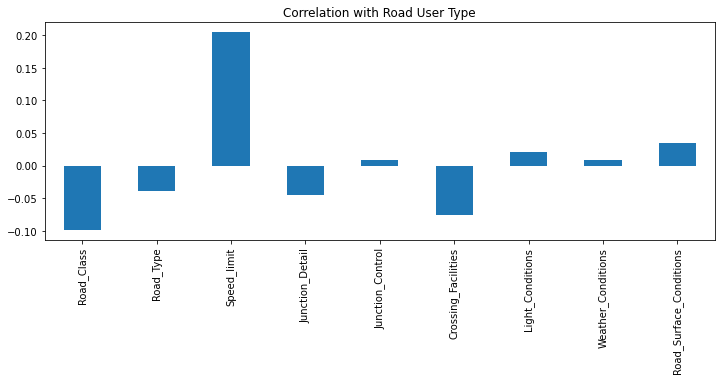

In [5]:
# Features
features = ["Road_Class", "Road_Type", "Speed_limit", "Junction_Detail", "Junction_Control", "Crossing_Facilities", 
            "Light_Conditions", "Weather_Conditions", "Road_Surface_Conditions"]

# Target variable
label = ["Road_User_Type"]
# label = ["Casualty_Severity"]

# Correlation barplot
df[features].corrwith(df[label[0]]).plot(kind="bar", title="Correlation with Road User Type", figsize=(12, 4))

In [6]:
# Split training and testing data 
X = df[features]
y = df[label].to_numpy().ravel()

# 33% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

print("Training data shape\nX: {}, y: {}".format(X_train.shape, y_train.shape))
print("Testing data shape\nX: {}, y: {}".format(X_test.shape, y_test.shape))

Training data shape
X: (72760, 9), y: (72760,)
Testing data shape
X: (35838, 9), y: (35838,)


**Forward Feature Selection**

In [7]:
## Use Forward Feature Selection to pick a good model

# Flag intermediate output for testing / debugging
show_steps = False

# Start with no predictors
included = []
# Keep track of model and parameters
best = {"feature": "", "accuracy": 0}
# Create a model object to hold the modelling parameters
# model = DecisionTreeClassifier(max_depth=7)
model = LGBMClassifier(objective="multiclass")

# Forward Feature Selection
while True:
    # Reset flag "changed"
    changed = False
    # Features that haven't been selected
    excluded = list(set(X.columns) - set(included))
    # Show excluded features
    if show_steps:
        print("(Step0) Excluded = %s" % ", ".join(excluded))
        
    # For-loop begins
    for col in excluded:
        # Show current testing feature
        if show_steps:
            print("(Step1) Trying [%s]" % col)
        # Fit model
        model.fit(X_train[included + [col]], y_train)
        # Calculate score
        accuracy = model.score(X_test[included + [col]], y_test)
        # Show current and best accuracy
        if show_steps:
            print("(Step2) Accuracy: This = %.3f; Best = %.3f" % (accuracy, best["accuracy"]))
                  
        # Update list "best" if model improves
        if accuracy > best["accuracy"]:
            best = {"feature": col, "accuracy": accuracy}
            # Update flag "changed"
            changed = True
            # Show list "best"
            if show_steps:
                print("NEW BEST FOUND! Feature = %s; Accuracy = %.3f" % (best["feature"], best["accuracy"]))
    # For-loop finishes
                  
    # If model improved, starts next round
    if changed:
        # Update list "included"
        included.append(best["feature"])
        # Show added feature
        if show_steps:
            print("Added feature: %s \n" % best["feature"])
    else:
        break

print("\nRESULTS")
print(", ".join(included))
print("Accuracy: %.3f" % best["accuracy"])


RESULTS
Speed_limit, Crossing_Facilities, Junction_Detail, Road_Type, Road_Class, Road_Surface_Conditions
Accuracy: 0.515


In [8]:
# Replace X with new features
X = df[included]

# 33% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

print("New training data shape\nX: {}, y: {}".format(X_train.shape, y_train.shape))
print("New testing data shape\nX: {}, y: {}".format(X_test.shape, y_test.shape))

New training data shape
X: (72760, 6), y: (72760,)
New testing data shape
X: (35838, 6), y: (35838,)


### 5.2 Modelling

**Problem Class:**  
Supervised Classification (multi-class)  

**Models:**  
Decision Tree  
Random Forest  
Extra Trees  
Ada Boost  
LightGBM  
K-Nearest Neighbors  

#### 5.2.1 Decision Tree

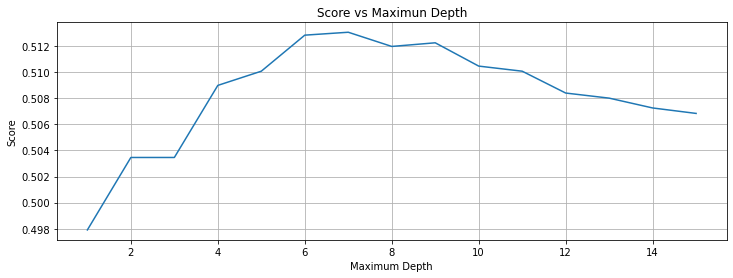

In [9]:
# Find best depth
max_depth = np.arange(1, 16)
score = []

for i in max_depth:
    dt = DecisionTreeClassifier(max_depth=i).fit(X_train, y_train)
    score.append(dt.score(X_test, y_test))

plt.figure(figsize=(12, 4))
plt.plot(max_depth, score)
plt.grid()
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.title("Score vs Maximun Depth")
plt.show()

In [10]:
best_depth = np.where(score == np.max(score))[0][0] + 1
print("Best Depth: %d" % best_depth)

Best Depth: 7


In [11]:
start = time.time()

# Create and fit model
dt = DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)

end = time.time()

time_dt = end - start

#### 5.2.2 Random Forest

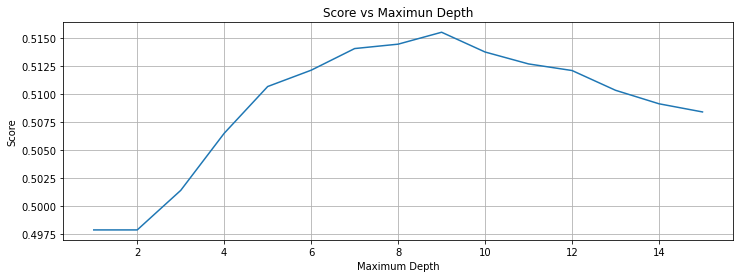

In [12]:
# Find best depth
max_depth = np.arange(1, 16)
score = []

for i in max_depth:
    rf = RandomForestClassifier(n_estimators=100, max_depth=i).fit(X_train, y_train)
    score.append(rf.score(X_test, y_test))

plt.figure(figsize=(12, 4))
plt.plot(max_depth, score)
plt.grid()
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.title("Score vs Maximun Depth")
plt.show()

In [13]:
best_depth = np.where(score == np.max(score))[0][0] + 1
print("Best Depth: %d" % best_depth)

Best Depth: 9


In [14]:
start = time.time()

# Create and fit model
rf = RandomForestClassifier(n_estimators=100, max_depth=best_depth).fit(X_train, y_train)

end = time.time()

time_rf = end - start

#### 5.2.3 Extra Trees

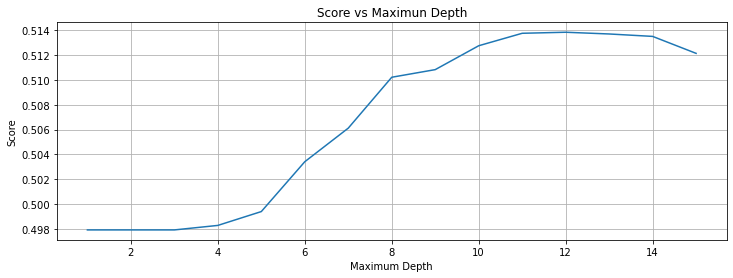

In [15]:
# Find best depth
max_depth = np.arange(1, 16)
score = []

for i in max_depth:
    et = ExtraTreesClassifier(n_estimators=100, max_depth=i, min_samples_leaf=2, n_jobs=-1).fit(X_train, y_train)
    score.append(et.score(X_test, y_test))

plt.figure(figsize=(12, 4))
plt.plot(max_depth, score)
plt.grid()
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.title("Score vs Maximun Depth")
plt.show()

In [16]:
best_depth = np.where(score == np.max(score))[0][0] + 1
print("Best Depth: %d" % best_depth)

Best Depth: 12


In [17]:
start = time.time()

# Create and fit model
et = ExtraTreesClassifier(n_estimators=100, max_depth=best_depth, min_samples_leaf=2, n_jobs=-1).fit(X_train, y_train)

end = time.time()

time_et = end - start

#### 5.2.4 Ada Boost

In [18]:
start = time.time()

# Create and fit model
ab = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)

end = time.time()

time_ab = end - start

#### 5.2.5 LightGBM

In [19]:
start = time.time()

# Create and fit model
lgbm = LGBMClassifier(objective="multiclass").fit(X_train, y_train)

end = time.time()

time_lgbm = end - start

#### 5.2.6 K-Nearest Neighbors

In [20]:
start = time.time()

# Create and fit model
knn = KNeighborsClassifier(n_neighbors=300).fit(X_train, y_train)

end = time.time()

time_knn = end - start

### 5.3 Testing

In [21]:
# Prediction
def prediction(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
#     precision = metrics.precision_score(y_test, y_pred, average="micro")
#     recall = metrics.recall_score(y_test, y_pred, average="micro")
    
    return accuracy#, precision, recall

In [22]:
# Baseline accuracy
baseline = round(df[label].value_counts().max() / df[label].value_counts().sum(), 4)
print(f"Baseline accuracy is {baseline * 100} %")

# Performance table
models = [dt, rf, et, ab, lgbm, knn]
performance = []

for model in models:
    performance.append(prediction(model, X_test, y_test))

df_performance = pd.DataFrame(performance, 
                              columns=["accuracy"],#, "precision", "recall"], 
                              index=["decision tree", "random forest", "extra tree", "ada boost", "light gbm", "k-nearest neighbors"])
df_performance = df_performance.assign(process_time = [time_dt, time_rf, time_et, time_ab, time_lgbm, time_knn])
df_performance

Baseline accuracy is 49.84 %


,accuracy,process_time
decision tree,0.513059,0.031073
random forest,0.515096,2.194902
extra tree,0.514147,0.814775
ada boost,0.334310,7.048878
light gbm,0.514733,5.691894
k-nearest neighbors,0.510826,3.190520


Both target variables are too extreme to be predicted. We conclude that the predictions of casualty severity and casualty type are not viable with the current information.

## 6. Identify Casualty Severity Groups by Roads

Use clustering method to identify what roads are more likely to have serious accidents.

In [23]:
# Copy data
df2 = df.copy()

# Slight damage -> 0
# Serious / Fatal -> 1
df2["Casualty_Severity"] = np.where(df2["Casualty_Severity"] == 3, 0, 1)

# Drop irrelevant columns
df2.drop(columns=["Accident_Index", "Accident_Severity", "Number_of_Casualties"], inplace=True)

In [24]:
# Drop target
df2_kmean = df2.drop(columns=["Casualty_Severity"]).copy()

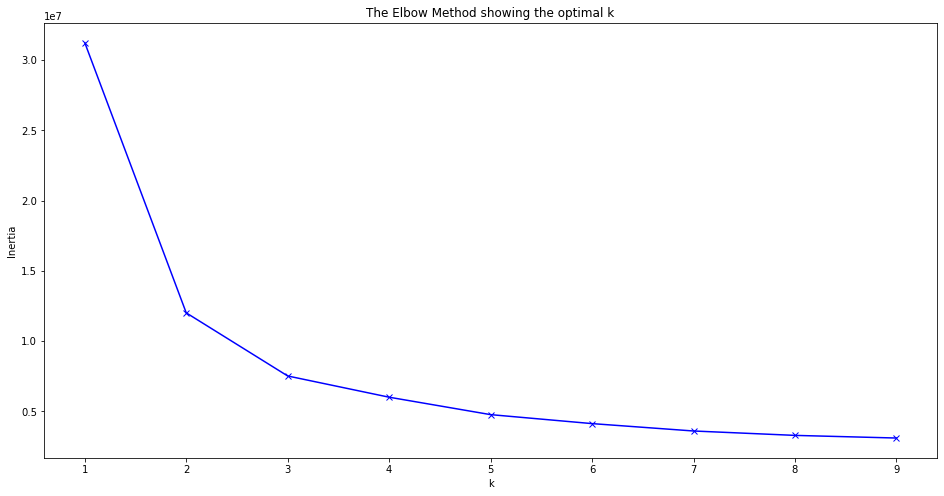

In [25]:
# Find inertias in a range of K
inertias = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(df2_kmean)
    inertias.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")

plt.show()

In [26]:
# Create and train k-mean model
k = 2
kmeans = KMeans(n_clusters=k, random_state=1).fit(df2_kmean)

Text(0.5, 1.0, 'Actual')

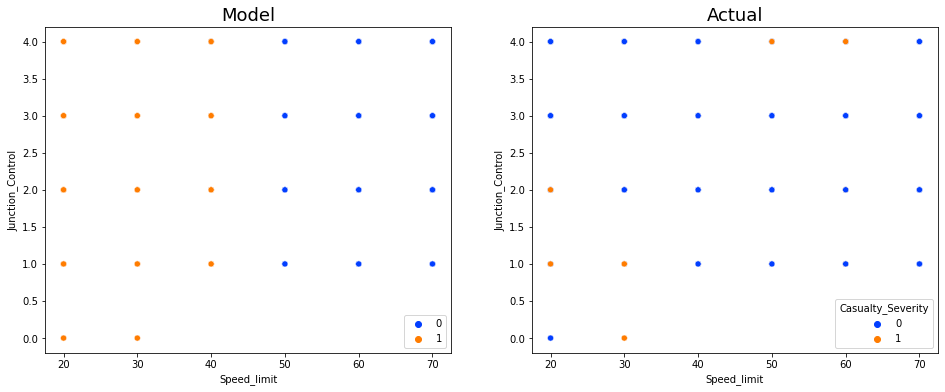

In [27]:
f, axes = plt.subplots(1, 2, figsize=(16, 6))
palette = sns.color_palette("bright", n_colors=2)

sns.scatterplot(x="Speed_limit", y="Junction_Control", data=df2_kmean, hue=kmeans.labels_, palette=palette, ax=axes[0])
axes[0].set_title("Model", fontsize=18)

sns.scatterplot(x="Speed_limit", y="Junction_Control", data=df2, hue="Casualty_Severity", palette=palette, ax=axes[1])
axes[1].set_title("Actual", fontsize=18)

Speed Limit has the most influence in casualty severity, and therefore the model split that into two groups based on Speed Limit.

Although machine learning methods could not predict how likely a serious accident would happen on a road, it indicated that Speed Limit was a major factor on fatal rate. We will look into the distribution of Speed Limit across different Road Class.

<Figure size 1152x288 with 0 Axes>

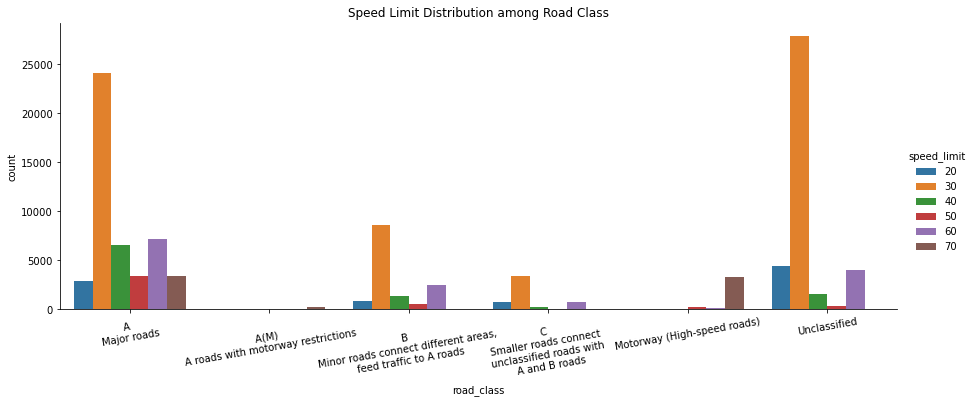

In [28]:
df = pd.read_sql_query("""
SELECT road_class, 
       speed_limit, 
       COUNT(road_class) AS count 
FROM accidents 
GROUP BY road_class, speed_limit;
""", conn)

fig = plt.figure(figsize=(16, 4))
ax = sns.catplot(data=df, x="road_class", y="count", hue="speed_limit", kind="bar", aspect=2.5)
ax.set_xticklabels(rotation=10)
plt.title("Speed Limit Distribution among Road Class")
plt.show()

Since traffic accident is directly associated with volumes, we can deploy flexible speed limit for the road that has high traffic volume. For example, when traffic volume is high, we lower the speed limit from 60 mph (\~96.6 kph) to 50 mph (~80 kph). This can reduce serious casualty for about 6.6 %.

## 7. Conclusion
See Report.docx